___
# **Starter code for BME 5710 project**
## Instructor -- Rizwan Ahmad (ahmad.46@osu.edu)
## BME5710 -- Spring 2025

___
### Import libraries and sub-libraries.

In [19]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.transforms import functional as TF
import torch.nn.functional as F
from torchmetrics.image.psnr import PeakSignalNoiseRatio
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure
# You can install torchmeterics using: pip install torchmetrics

___
### Calling a custom code to change the default font for figures to `Computer Modern`. (Optional)

In [20]:
from fontsetting import font_cmu
plt = font_cmu(plt)

___
### Check the hardware that is at your disposal

In [21]:
import torch

print("Torch version:", torch.__version__)
print("MPS available:", torch.backends.mps.is_available())
print("MPS built:", torch.backends.mps.is_built())

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)


Torch version: 2.5.1
MPS available: True
MPS built: True
Using device: mps


___
### Read training data from `data/train/hig-res` and `data/train/low-res`


In [22]:
# Loading TIFF images for Super-resolution
class TIFFDataset(Dataset):
    def __init__(self, high_res_dir, low_res_dir, transform=None):
        self.high_res_dir = high_res_dir
        self.low_res_dir = low_res_dir
        self.transform = transform
        self.filenames = sorted([f for f in os.listdir(high_res_dir) if f.endswith('.tif')])
    
    # Get the number of samples in the dataset
    def __len__(self):
        return len(self.filenames)

    # Get the sample at the given index
    def __getitem__(self, idx):
        high_res_path = os.path.join(self.high_res_dir, self.filenames[idx])
        low_res_path = os.path.join(self.low_res_dir, self.filenames[idx])

        # Load images
        high_res = Image.open(high_res_path)
        low_res = Image.open(low_res_path)

        # Resize low-res to 128x128 (ensuring correct input size)
        low_res = low_res.resize((128, 128), Image.BICUBIC)

        # Apply transformations
        if self.transform:
            high_res = self.transform(high_res)
            low_res = self.transform(low_res)

        return low_res, high_res  # Returning input-output pairs

# Define a transform to convert images to PyTorch tensors
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create the dataset for training images
train_dataset = TIFFDataset('data/train/high-res', 'data/train/low-res', transform=transform)

# Function to create data loader
def create_loader(dataset, batch_size):
    torch.manual_seed(0)  # For reproducibility
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Print dataset size
dataset_size = len(train_dataset)
print('Number of images in the dataset:', dataset_size)

Number of images in the dataset: 240


___
### Define a super-resolution network

#### Here, I have defined a trivial network, which has only two layers and no activation function. We are essentially doing linear filtering.

In [23]:
class TrivialNet(nn.Module):
    def __init__(self):
        super(TrivialNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv1(x)  # First conv layer
        x = self.conv2(x)  # Output layer
        return x

___
### Create a function to execute training. Note, we will call this function later.

In [24]:
def train_model(model, opt, criterion, train_loader, num_epoch):
    avg_train_losses = []

    for epoch in range(num_epoch):  # Loop over the dataset multiple times
        model.train()
        total_train_loss = 0

        for i, (x_tr_batch, y_tr_batch) in enumerate(train_loader):  # Loop over mini-batches
            x_tr_batch, y_tr_batch = x_tr_batch.to(device), y_tr_batch.to(device)

            # # Upsample low-resolution input to 256x256
            # x_tr_batch = torch.nn.functional.interpolate(x_tr_batch, scale_factor=2, mode='bicubic', align_corners=False)
            x_tr_batch = torch.nn.functional.interpolate(x_tr_batch, scale_factor=2, mode='bilinear', align_corners=False)

            opt.zero_grad()  # Delete previous gradients
            y_hat_tr_batch = model(x_tr_batch)  # Forward pass
            loss = criterion(y_hat_tr_batch, y_tr_batch)  # Compute loss
            loss.backward()  # Backward pass
            opt.step()  # Update weights
            total_train_loss += loss.item()  # Accumulate loss

            if (i + 1) % 10 == 0:
                print(f'Epoch {epoch+1}, Iteration {i+1}, Loss: {loss.item():.6f}')

        avg_train_loss = total_train_loss / len(train_loader)  # Compute average loss
        avg_train_losses.append(avg_train_loss)  # Store average loss

    # Plot training loss
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(range(1, num_epoch + 1), avg_train_losses, label='training loss')
    ax.set_xlabel('epochs')
    ax.set_ylabel('MSE loss')
    ax.set_yscale('log')  # Log scale for better visualization
    ax.set_title('training loss')
    ax.grid(True)
    ax.legend()
    plt.show()

___
### Now, let us define hyperparameters and train the network. 

#### Note, in addition to the parameters that controls the network architecture or the training process, you need to select/initialize (i) a data loader, (ii) a model, (iii) an optimizer, and (iv) a loss function.

In [ ]:
batch_size = 5  # Number of complete images in each batch
lr = 1e-3  # Learning rate
num_epoch = 100  # Epochs

# Model, criterion, and optimizer
train_loader = create_loader(train_dataset, batch_size)
model = TrivialNet().to(device)  # Pick a model and move to GPU/CPU
opt = optim.Adam(model.parameters(), lr=lr)  # Pick an optimizer
criterion = nn.MSELoss()  # Pick a loss function

# Train the model
train_model(model, opt, criterion, train_loader, num_epoch)

Epoch 1, Iteration 10, Loss: 0.003212
Epoch 1, Iteration 20, Loss: 0.002613
Epoch 1, Iteration 30, Loss: 0.002880
Epoch 1, Iteration 40, Loss: 0.002189
Epoch 2, Iteration 10, Loss: 0.001971
Epoch 2, Iteration 20, Loss: 0.001873
Epoch 2, Iteration 30, Loss: 0.001706
Epoch 2, Iteration 40, Loss: 0.001665
Epoch 3, Iteration 10, Loss: 0.001799
Epoch 3, Iteration 20, Loss: 0.001515
Epoch 3, Iteration 30, Loss: 0.001490
Epoch 3, Iteration 40, Loss: 0.001408
Epoch 4, Iteration 10, Loss: 0.001324
Epoch 4, Iteration 20, Loss: 0.001283
Epoch 4, Iteration 30, Loss: 0.001125
Epoch 4, Iteration 40, Loss: 0.001134
Epoch 5, Iteration 10, Loss: 0.001156
Epoch 5, Iteration 20, Loss: 0.000958
Epoch 5, Iteration 30, Loss: 0.000973
Epoch 5, Iteration 40, Loss: 0.001049
Epoch 6, Iteration 10, Loss: 0.001087
Epoch 6, Iteration 20, Loss: 0.000953
Epoch 6, Iteration 30, Loss: 0.001016
Epoch 6, Iteration 40, Loss: 0.000830
Epoch 7, Iteration 10, Loss: 0.000871
Epoch 7, Iteration 20, Loss: 0.000858
Epoch 7, Ite

___
### Apply it one of the validation image

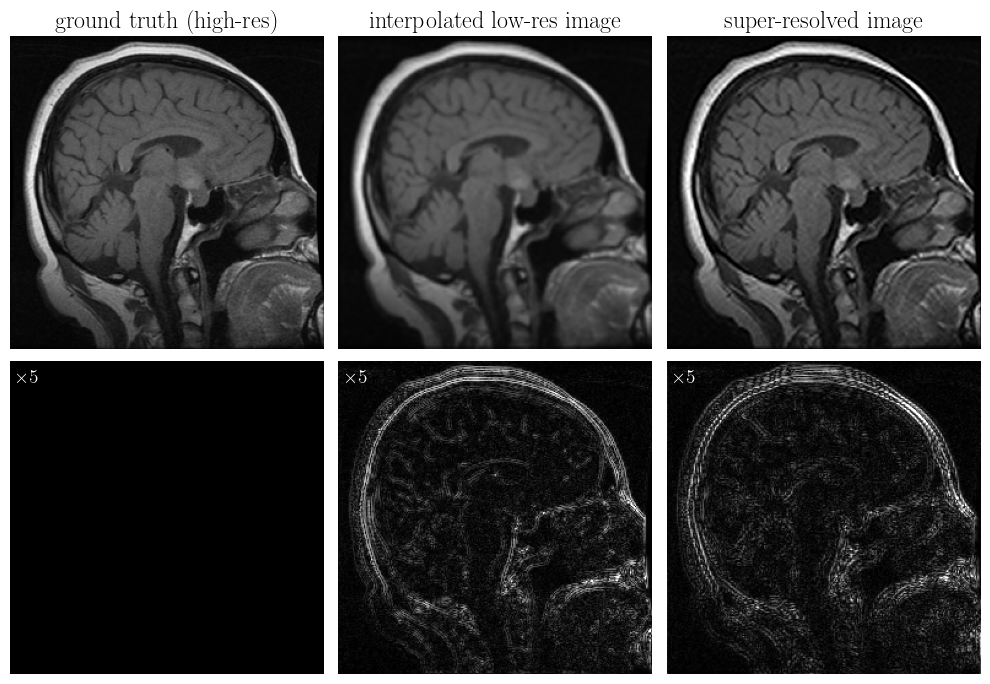

In [12]:
# Create the dataset for validation images
val_dataset = TIFFDataset('data/val/high-res', 'data/val/low-res', transform=transform)

# Load one (low-res, high-res) image pair from validation dataset and move it to the dedvice
val_low_res, val_high_res = val_dataset[1]  # Input (128x128), Ground truth (256x256)
val_low_res, val_high_res = val_low_res.to(device), val_high_res.to(device)

# Upsample low-resolution image to 256x256 for both model input and error visualization
# val_low_res_interpolated = torch.nn.functional.interpolate(val_low_res.unsqueeze(0), scale_factor=2, mode='bicubic', align_corners=False).squeeze(0)
val_low_res_interpolated = torch.nn.functional.interpolate(val_low_res.unsqueeze(0).cpu(), scale_factor=2, mode='bicubic', align_corners=False).squeeze(0).to(device)

# Apply the trained model to super-resolve the interpolated low-res image
val_super_res = model(val_low_res_interpolated.unsqueeze(0)).detach().squeeze(0)  # Remove batch dimension

# Convert tensors to numpy for visualization
val_low_res_np = val_low_res_interpolated.squeeze().cpu().numpy()  # Use the interpolated version for error maps
val_high_res_np = val_high_res.squeeze().cpu().numpy()
val_super_res_np = val_super_res.squeeze().cpu().numpy()

# Plot an example image and error maps
fig, ax = plt.subplots(2, 3, figsize=(10, 7))

# Plot images
ax[0, 0].imshow(val_high_res_np, cmap='gray', vmin=0, vmax=1)
ax[0, 0].set_title('ground truth (high-res)')
ax[0, 0].axis('off')

ax[0, 1].imshow(val_low_res_np, cmap='gray', vmin=0, vmax=1)
ax[0, 1].set_title('interpolated low-res image')
ax[0, 1].axis('off')

ax[0, 2].imshow(val_super_res_np, cmap='gray', vmin=0, vmax=1)
ax[0, 2].set_title('super-resolved image')
ax[0, 2].axis('off')

# Error maps
ax[1, 0].imshow(5 * np.abs(val_high_res_np - val_high_res_np), cmap='gray', vmin=0, vmax=1)
ax[1, 0].axis('off')
ax[1, 0].text(0.02, 0.98, r'$\times 5$', transform=ax[1, 0].transAxes, fontsize=14, va='top', ha='left', color='white')

ax[1, 1].imshow(5 * np.abs(val_high_res_np - val_low_res_np), cmap='gray', vmin=0, vmax=1)
ax[1, 1].axis('off')
ax[1, 1].text(0.02, 0.98, r'$\times 5$', transform=ax[1, 1].transAxes, fontsize=14, va='top', ha='left', color='white')

ax[1, 2].imshow(5 * np.abs(val_high_res_np - val_super_res_np), cmap='gray', vmin=0, vmax=1)
ax[1, 2].axis('off')
ax[1, 2].text(0.02, 0.98, r'$\times 5$', transform=ax[1, 2].transAxes, fontsize=14, va='top', ha='left', color='white')

plt.tight_layout()
plt.show()

### Compute PSNR and SSIM over the entire validation dataset

In [ ]:
# Initialize metrics
psnr_metric = PeakSignalNoiseRatio().to(device)
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

# Accumulators
total_psnr_interpolated = 0
total_psnr_super_resolved = 0
total_ssim_interpolated = 0
total_ssim_super_resolved = 0
num_samples = len(val_dataset)

# Loop over validation set
for i in range(num_samples):
    val_low_res, val_high_res = val_dataset[i]
    val_low_res, val_high_res = val_low_res.to(device), val_high_res.to(device)

    # Compute data range dynamically
    data_range = val_high_res.max() - val_high_res.min()
    ssim_metric.data_range = data_range

    # Upsample low-res image
    val_low_res_interpolated = torch.nn.functional.interpolate(
        val_low_res.unsqueeze(0), scale_factor=2, mode='bicubic', align_corners=False
    ).to(device)

    val_high_res = val_high_res.unsqueeze(0)  # Add batch dim
    val_super_res = model(val_low_res_interpolated).detach()

    # PSNR
    psnr_interp = psnr_metric(val_low_res_interpolated, val_high_res).item()
    psnr_sr = psnr_metric(val_super_res, val_high_res).item()

    # SSIM
    ssim_interp = ssim_metric(val_low_res_interpolated, val_high_res).item()
    ssim_sr = ssim_metric(val_super_res, val_high_res).item()

    # Accumulate
    total_psnr_interpolated += psnr_interp
    total_psnr_super_resolved += psnr_sr
    total_ssim_interpolated += ssim_interp
    total_ssim_super_resolved += ssim_sr

# Averages
avg_psnr_interp = total_psnr_interpolated / num_samples
avg_psnr_sr = total_psnr_super_resolved / num_samples
avg_ssim_interp = total_ssim_interpolated / num_samples
avg_ssim_sr = total_ssim_super_resolved / num_samples

# Print results
print(f'Average PSNR (interpolated): {avg_psnr_interp:.2f} dB')
print(f'Average PSNR (super-resolved): {avg_psnr_sr:.2f} dB')
print(f'Average SSIM (interpolated): {avg_ssim_interp:.4f}')
print(f'Average SSIM (super-resolved): {avg_ssim_sr:.4f}')


NotImplementedError: The operator 'aten::upsample_bicubic2d.out' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.